In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib.patches import Ellipse

from abc import ABC, abstractmethod

In [2]:
class Neuron:
    def __init__(self, mean, cov, coord):
        self.mean_ = mean
        self.cov_ = cov
        self.coord_ = coord

In [13]:
class Lattice(ABC):
    def __init__(self, size):
        self.size_ = size
        self.neurons_ = None
        self.neurons_nb_ = None

        self.generate()

    @abstractmethod
    def generate(self):
        pass


class RectangularLattice(Lattice):
    def generate(self):
        self.neurons_ = []
        self.neurons_nb_ = self.size_[0] * self.size_[1]

        for i in range(0, self.size_[0]):
            for j in range(0, self.size_[1]):
                self.neurons_.append(Neuron(None, None, np.array([i, j])))


In [14]:
class SOMM:
    def __init__(self, lattice: Lattice, learning_rate):
        self.learning_rate_ = learning_rate
        self.alpha_ = None
        self.lattice_ = lattice

    def fit(self, X: np.ndarray, epochs):
        neurons_nb = self.lattice_.neurons_nb_
        neurons = self.lattice_.neurons_

        indexes = np.random.choice(X.shape[0], neurons_nb, replace=False)

        for i in range(0, neurons_nb):
            neurons[i].mean_ = X[indexes[i]]
            neurons[i].cov_ = self.initialize_cov(X.shape[1])
            print(neurons[i].cov_)

        for ep in range(epochs):
            self.alpha_ = np.sqrt(ep + 1) * self.learning_rate_
            print("Epoch:", ep)
            print("1/2*sigma^2:", self.alpha_)
            print("Weights, Covariance:")
            for neuron in self.lattice_.neurons_:
                print(neuron.mean_, end=' ')
                print(neuron.cov_, end=' ')
            print()

            bmus_idx = []
            for x in X:
                # Find best matching unit for x_n
                winner_idx = self.find_bmu(x)
                bmus_idx.append(winner_idx)

            # Update nodes
            self.update_nodes(bmus_idx, X)

    def neighbourhood_func(self, r, s):
        # r - fixed neuron index
        # s - arbitrary neuron index

        numerator = np.exp(-self.alpha_ * self.distance(self.lattice_.neurons_[r].coord_, self.lattice_.neurons_[s].coord_))
        denominator = 0

        for neuron in self.lattice_.neurons_:
            denominator += np.exp(-self.alpha_ * self.distance(self.lattice_.neurons_[r].coord_, neuron.coord_))

        return numerator / denominator

    def find_bmu(self, x):
        # returns winner_idx
        min_d = np.inf
        winner_idx = None

        for i in range(self.lattice_.neurons_nb_):
            d = self.bmu_distance(x, i)
            if d < min_d:
                min_d = d
                winner_idx = i

        return winner_idx

    @staticmethod
    def distance(v1: np.ndarray, v2: np.ndarray):
        # Calculating euclidian distance
        return np.sqrt(np.sum((v1 - v2) ** 2))

    def bmu_distance(self, x, neuron_idx):
        distance = 0
        for i, neuron in enumerate(self.lattice_.neurons_):
            nb_val = self.neighbourhood_func(neuron_idx, i)

            #distance += nb_val * (self.distance(x, self.lattice_.neurons_[i].mean_) / 2 + np.log(nb_val))
            distance += nb_val * ((np.log(np.linalg.det(neuron.cov_)) + (x - neuron.mean_).T @ np.linalg.inv(neuron.cov_) @ (x - neuron.mean_))/2 + np.log(nb_val))

        return distance

    def update_nodes(self, bmus_idx, X):
        # Updating all neuron based on batch mode

        for neuron_idx in range(self.lattice_.neurons_nb_):
            numerator_mean = 0
            numerator_cov = 0
            denominator = 0

            for i, x in enumerate(X):
                nb_val = self.neighbourhood_func(bmus_idx[i], neuron_idx)

                numerator_cov += nb_val * np.outer((x - self.lattice_.neurons_[neuron_idx].mean_), (x - self.lattice_.neurons_[neuron_idx].mean_))
                numerator_mean += nb_val * x
                denominator += nb_val

            self.lattice_.neurons_[neuron_idx].mean_ = numerator_mean / denominator
            self.lattice_.neurons_[neuron_idx].cov_ = (numerator_cov / denominator).reshape(X.shape[1], X.shape[1])
            
    
    @staticmethod
    def initialize_cov(n):
        upper_triangle_values = np.random.rand(n * (n - 1) // 2)

        # Construct the full covariance matrix by filling both upper and lower triangles
        cov_matrix = np.zeros((n, n))
        cov_matrix[np.triu_indices(n, k=1)] = upper_triangle_values
        cov_matrix = cov_matrix + cov_matrix.T

        # # Set the diagonal elements to 1
        np.fill_diagonal(cov_matrix, 1.0)
        return cov_matrix

### Example 1

Text(0.5, 1.0, '1D Gaussian Mixture Dataset')

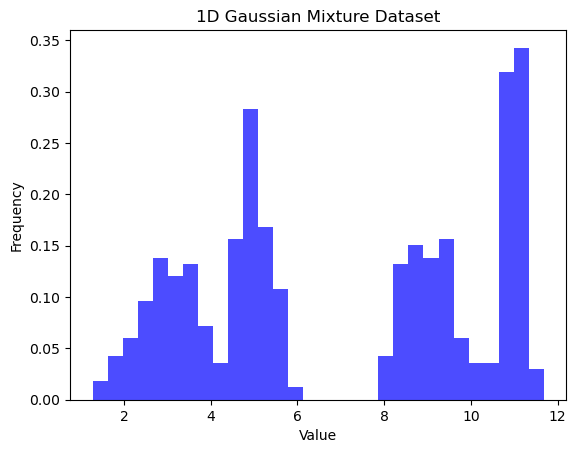

In [229]:
# Define the parameters for the Gaussian mixture
means = np.array([3, 5, 9, 11])
variances = np.array([0.7, 0.4, 0.5, 0.2])  # Common variance for all components
n_samples = 120

# Generate data points from the Gaussian mixture
data = np.concatenate([np.random.normal(means[i], variances[i], n_samples) for i in range(len(means))])

# Visualize the generated data
hist_data, bin_edges, _ = plt.hist(data, bins=30, density=True, alpha=0.7, color='b')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('1D Gaussian Mixture Dataset')

In [230]:
data

array([ 1.4552329 ,  3.44506988,  1.73602277,  4.14053653,  1.82064696,
        4.59222602,  3.64184984,  3.60018062,  2.12707039,  2.8266026 ,
        3.57747738,  2.36666354,  4.17561271,  3.3734172 ,  1.92517675,
        1.4103285 ,  2.58834048,  3.05486249,  2.69228531,  2.28321856,
        1.70417554,  3.84289632,  2.83346616,  2.44268327,  3.40411499,
        3.4533596 ,  2.91390552,  2.95076512,  3.55573137,  4.65095103,
        4.94119877,  3.26196892,  4.78590467,  1.99094825,  3.41908893,
        2.76836714,  3.14648806,  4.03268637,  3.8582276 ,  2.28159224,
        2.78504865,  3.12683801,  1.9220665 ,  3.77976551,  2.80072231,
        4.0377205 ,  3.18255116,  2.78816117,  1.76289226,  3.40790429,
        2.22667697,  2.84351305,  3.23195642,  2.79466354,  3.16262996,
        3.38274259,  3.19494693,  3.39243666,  3.0599886 ,  3.09955418,
        2.61150312,  2.93309193,  3.88411944,  3.50165759,  2.65878986,
        2.39861702,  2.84093293,  1.2824039 ,  2.70732406,  3.41

In [231]:
X = data.reshape(-1, 1)
X

array([[ 1.4552329 ],
       [ 3.44506988],
       [ 1.73602277],
       [ 4.14053653],
       [ 1.82064696],
       [ 4.59222602],
       [ 3.64184984],
       [ 3.60018062],
       [ 2.12707039],
       [ 2.8266026 ],
       [ 3.57747738],
       [ 2.36666354],
       [ 4.17561271],
       [ 3.3734172 ],
       [ 1.92517675],
       [ 1.4103285 ],
       [ 2.58834048],
       [ 3.05486249],
       [ 2.69228531],
       [ 2.28321856],
       [ 1.70417554],
       [ 3.84289632],
       [ 2.83346616],
       [ 2.44268327],
       [ 3.40411499],
       [ 3.4533596 ],
       [ 2.91390552],
       [ 2.95076512],
       [ 3.55573137],
       [ 4.65095103],
       [ 4.94119877],
       [ 3.26196892],
       [ 4.78590467],
       [ 1.99094825],
       [ 3.41908893],
       [ 2.76836714],
       [ 3.14648806],
       [ 4.03268637],
       [ 3.8582276 ],
       [ 2.28159224],
       [ 2.78504865],
       [ 3.12683801],
       [ 1.9220665 ],
       [ 3.77976551],
       [ 2.80072231],
       [ 4

In [207]:
X.shape

(480, 1)

In [211]:
lattice = RectangularLattice((2, 2))
som = SOMM(lattice, 1.005)

In [212]:
som.fit(X, 300)

Epoch: 0
1/2*sigma^2: 1.005
Weights, Covariance:
[9.13181996] [[1.]] [2.90241067] [[1.]] [11.08483708] [[1.]] [5.07547097] [[1.]] 
Epoch: 1
1/2*sigma^2: 1.4212846301849604
Weights, Covariance:
[7.41105507] [[11.73656227]] [5.30663436] [[14.00338623]] [8.7521085] [[13.31762415]] [6.58627495] [[10.79283086]] 
Epoch: 2
1/2*sigma^2: 1.7407110616067214
Weights, Covariance:
[7.15121588] [[9.86866644]] [4.68130565] [[5.96516464]] [9.26073172] [[5.36403648]] [6.69299468] [[8.27884551]] 
Epoch: 3
1/2*sigma^2: 2.01
Weights, Covariance:
[7.03245878] [[10.04461419]] [4.53634793] [[3.88021017]] [9.52856964] [[3.81242281]] [7.03245878] [[10.14574682]] 
Epoch: 4
1/2*sigma^2: 2.2472483173872884
Weights, Covariance:
[7.03245878] [[10.03051094]] [4.39704851] [[3.16709071]] [9.66786905] [[3.04196521]] [7.03245878] [[10.03051094]] 
Epoch: 5
1/2*sigma^2: 2.4617371914970936
Weights, Covariance:
[7.03245878] [[10.03051094]] [4.30779808] [[2.67938215]] [9.75711948] [[2.55001916]] [7.03245878] [[10.03051094]] 

In [215]:
for neuron in som.lattice_.neurons_:
    print(neuron.mean_, neuron.cov_)

[8.97197848] [[0.2454862]]
[3.01659769] [[0.40854023]]
[11.01609677] [[0.04381583]]
[5.05714397] [[0.17923677]]


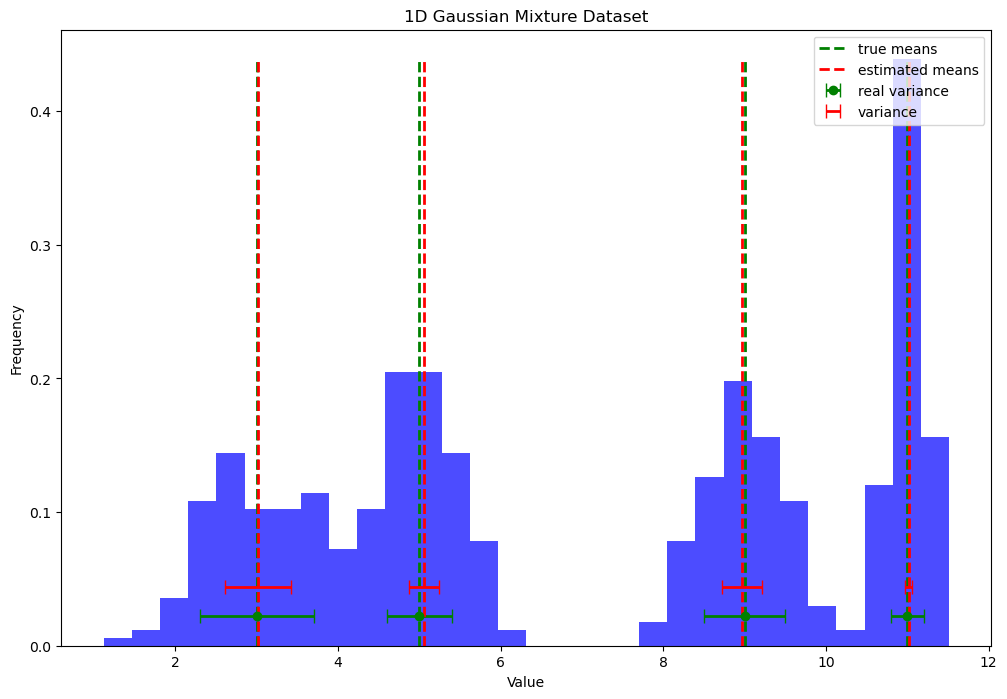

In [216]:
fig, ax = plt.subplots(figsize=(12, 8))

# Visualize the generated data
ax.hist(data, bins=30, density=True, alpha=0.7, color='b')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('1D Gaussian Mixture Dataset')

neuron_variances = np.array([neuron.cov_[0] for neuron in som.lattice_.neurons_]).flatten()
neuron_weights = np.array([neuron.mean_ for neuron in som.lattice_.neurons_]).flatten()

# Plot vertical lines for real means:
ax.vlines(x=means, color='g', linestyle='--', linewidth=2, label='true means', ymin=0, ymax=max(hist_data))
ax.errorbar(means, np.full(len(means), max(hist_data) * 0.05), xerr=variances, fmt='go', elinewidth=2, capsize=5, label='real variance')

# Plot vertical lines for neuron weights
ax.vlines(x=neuron_weights, color='r', linestyle='--', linewidth=2, label='estimated means', ymin=0, ymax=max(hist_data))
ax.errorbar(x=neuron_weights, y=np.full(len(neuron_weights), max(hist_data) * 0.1), xerr=neuron_variances, color='r', fmt='none', elinewidth=2, capsize=5, label='variance')


ax.legend(loc='upper right');

### Example 2

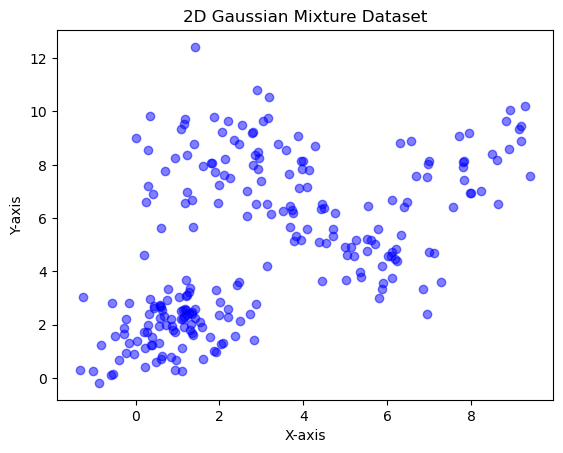

In [9]:
# Define the parameters for the 2D Gaussian mixture
means = np.array([[1, 2], [5, 5], [8, 8], [2, 8]])
covariances = np.array([[[1, 0.5], [0.5, 1]],
                        [[1, -0.5], [-0.5, 1]],
                        [[1, 0.5], [0.5, 1]],
                        [[1.3, 0], [0, 1.3]]])

n_samples = [100, 50, 30, 60]

# Generate data points from the 2D Gaussian mixture
data = np.concatenate([np.random.multivariate_normal(mean, cov, n) for mean, cov, n in zip(means, covariances, n_samples)])

# Visualize the generated data
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, color='b')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Gaussian Mixture Dataset')

plt.show()

In [10]:
data

array([[ 5.48698966e-01,  1.30967729e+00],
       [-1.63596000e-01,  2.81867819e+00],
       [ 2.25707791e-01,  4.21490730e-01],
       [ 4.35067048e-01,  2.68854500e+00],
       [ 1.28225213e+00,  3.22419730e+00],
       [ 9.38616808e-01,  1.74616232e+00],
       [ 2.07574682e+00,  1.30355366e+00],
       [ 1.36591097e+00,  1.61198085e+00],
       [ 5.84953829e-01,  2.73583851e+00],
       [ 4.41684469e-01,  2.64318021e+00],
       [ 1.20004365e+00,  3.67151507e+00],
       [ 1.19768441e+00,  2.55511255e+00],
       [ 1.17621429e+00,  2.57506353e+00],
       [ 5.74484092e-01,  2.26117761e+00],
       [ 2.12050994e-01,  1.71593615e+00],
       [ 1.91561364e+00,  9.94302345e-01],
       [ 8.53833355e-01,  2.19954122e+00],
       [ 6.21201775e-01,  8.26186401e-01],
       [ 1.60288670e+00,  7.19726671e-01],
       [ 1.99617461e+00,  2.35861990e+00],
       [ 1.52865238e+00,  2.11978293e+00],
       [ 7.20959926e-01,  1.97287544e+00],
       [ 2.88269837e+00,  2.76532499e+00],
       [ 2.

In [23]:
lattice = RectangularLattice((2, 2))
som = SOMM(lattice, 1.005)

In [24]:
som.fit(data, 200)

[[1.         0.26505675]
 [0.26505675 1.        ]]
[[1.         0.34814808]
 [0.34814808 1.        ]]
[[1.         0.94016732]
 [0.94016732 1.        ]]
[[1.       0.110242]
 [0.110242 1.      ]]
Epoch: 0
1/2*sigma^2: 1.005
Weights, Covariance:
[6.29532602 8.80279847] [[1.         0.26505675]
 [0.26505675 1.        ]] [2.88269837 2.76532499] [[1.         0.34814808]
 [0.34814808 1.        ]] [0.68831783 2.32003276] [[1.         0.94016732]
 [0.94016732 1.        ]] [3.03086099 9.65080558] [[1.       0.110242]
 [0.110242 1.      ]] 
Epoch: 1
1/2*sigma^2: 1.4212846301849604
Weights, Covariance:
[3.94577573 5.45329814] [[14.7197757  13.48328786]
 [13.48328786 19.59028534]] [3.1166967  4.81990794] [[ 6.13131215  2.48537843]
 [ 2.48537843 12.12746633]] [2.17535473 4.02773704] [[ 8.70685209  7.46896886]
 [ 7.46896886 11.20581412]] [2.79009004 5.5414434 ] [[ 5.10234591  3.75060692]
 [ 3.75060692 26.20808279]] 
Epoch: 2
1/2*sigma^2: 1.7407110616067214
Weights, Covariance:
[4.62271597 5.6290224

In [27]:
for neuron in som.lattice_.neurons_:
    print(neuron.mean_)
    print(neuron.cov_)
    print()

[7.81892149 8.03766084]
[[1.12431797 0.62295174]
 [0.62295174 1.24183571]]

[5.13129456 5.00463244]
[[ 1.1670956  -0.80828124]
 [-0.80828124  1.1392683 ]]

[0.8940158 1.9429305]
[[0.87679529 0.34666485]
 [0.34666485 0.85280389]]

[2.13462622 8.22261069]
[[1.29169912 0.32221804]
 [0.32221804 1.82987391]]



In [28]:
neuron_variances = np.array([neuron.cov_ for neuron in som.lattice_.neurons_])
neuron_weights = np.array([neuron.mean_ for neuron in som.lattice_.neurons_])

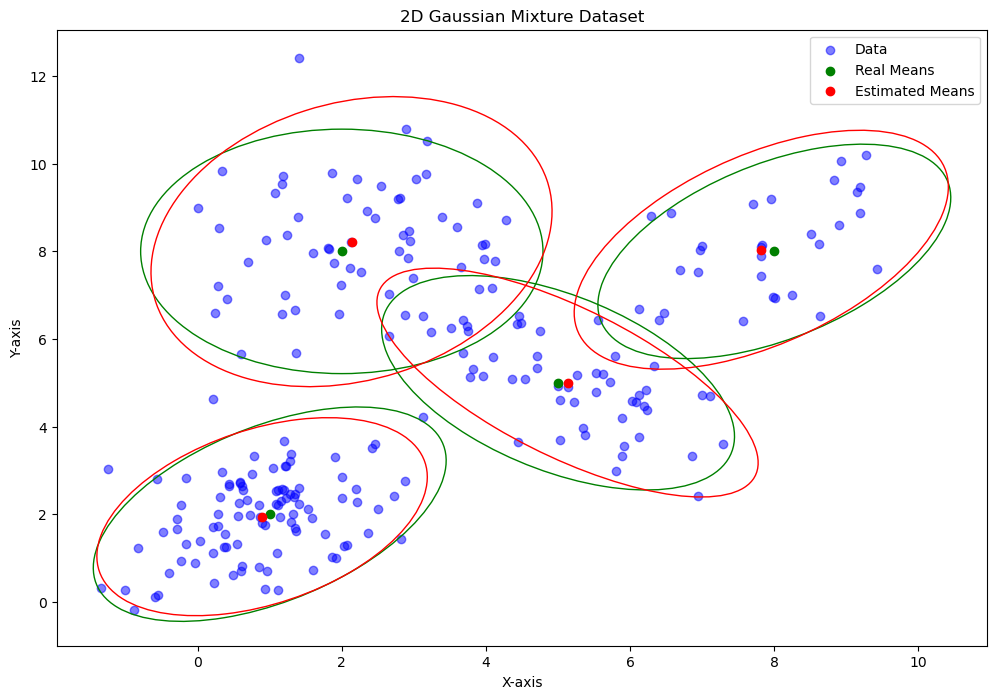

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(data[:, 0], data[:, 1], alpha=0.5, color='b', label='Data')

# Plot means as green points
ax.scatter(means[:, 0], means[:, 1], color='g', marker='o', label='Real Means')

# Plot true parameters
for mean, cov in zip(means, covariances):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)  # 95% confidence interval
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color='g', fill=False)
    ax.add_patch(ell)

# Plot means as red points
ax.scatter(neuron_weights[:, 0], neuron_weights[:, 1], color='r', marker='o', label='Estimated Means')

# Plot neuron parameters
for mean, cov in zip(neuron_weights, neuron_variances):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)  # 95% confidence interval
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color='r', fill=False)
    ax.add_patch(ell)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Gaussian Mixture Dataset')
ax.legend(loc='best');